# TSSL Lab 1 - Autoregressive models

- Qinyuan QI(qinqi464)

We load a few packages that are useful for solvign this lab assignment.

In [25]:
# Loading data / handling data frames
import pandas  
import numpy as np
import matplotlib.pyplot as plt

# Used for solving linear regression problems
from sklearn import linear_model as lm  
# Used for NAR model
from sklearn.neural_network import MLPRegressor 
# Module available in LISAM - Used for plotting ACF
from tssltools_lab1 import acf, acfplot 

# export plot as svg to pdf
# need inkScape installed to export pdf (support svg in the pdf)
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

## 1.1 Loading, plotting and detrending data

In this lab we will build autoregressive models for a data set corresponding to the Global Mean Sea Level (GMSL) over the past few decades. The data is taken from https://climate.nasa.gov/vital-signs/sea-level/ and is available on LISAM in the file `sealevel.csv`.

**Q1**: Load the data and plot the GMSL versus time. How many observations are there in total in this data set?

_Hint:_ With pandas you can use the function `pandas.read_csv` to read the csv file into a data frame. Plotting the time series can be done using `pyplot`. Note that the sea level data is stored in the 'GMSL' column and the time when each data point was recorded is stored in the column 'Year'.

**A1**:

Accoring to the data, there are 1119 observations in total.

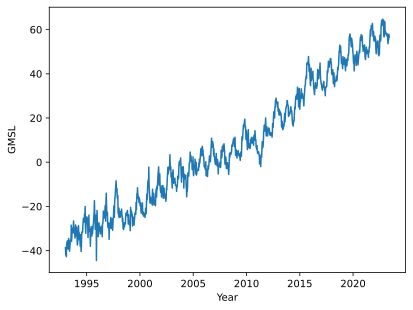

1119


In [26]:
# load the csv file, will use the 1st row as column name by default (infer)
data = pandas.read_csv('sealevel.csv', header="infer")

# get the plot data (GMSL and Year)
plot_data = data[['GMSL', 'Year']]

# plot the data(can not specify x and y here)
plt.plot("Year","GMSL",data=plot_data)
plt.xlabel('Year')
plt.ylabel('GMSL')
plt.show()

# print the number of observations
print(np.shape(data)[0])

**Q2**: The data has a clear upward trend. Before fitting an AR model to this data need to remove this trend. Explain, using one or two sentences, why this is necessary.

**A2:** To fit an A model, we need to make sure the data is stationary. In the case of weak stationary, we need make sure 

1. $\mu=const$
2. $var \lt \infty$ , and $var$ is independent of t
3. autocovariance function only depend on the lag. 

In our case, the data has a uptrend, so to fit an AR model, we need to remove the trend by subtracting the mean of the the origial data.

**Q3** Detrend the data following these steps:
1. Fit a straight line, $\mu_t=\theta_0 + \theta_1 u_t$ to the data based on the method of least squares. Here, $u_t$ is the time point when obervation $t$ was recorded.

_Hint:_ You can use lm.LinearRegression().fit(...) from scikit-learn. Note that the inputs need to be passed as a 2D array.

Before going on to the next step, plot your fitted line and the data in one figure.

2. Subtract the fitted line from $y_t$ for the whole data series and plot the deviations from the straight line.

**From now, we will use the detrended data in all parts of the lab.**

_Note:_ The GMSL data is recorded at regular time intervals, so that $u_{t+1} - u_t = const$. Therefore, you can just as well use $t$ directly in the linear regression function if you prefer, $\mu_t=\theta_0 + \theta_1 t$.

**A3:**

Code as follows.

The fitted line is: u =  -6385.358282332335 + 3.1835977252943035 u


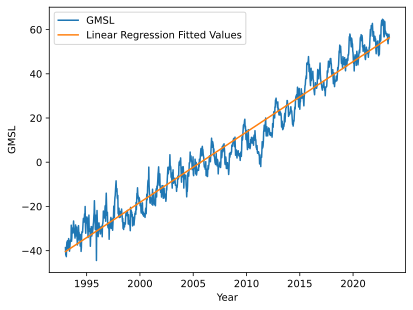

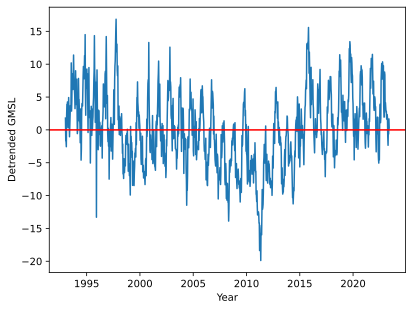

In [27]:
# prep the data to train linear regression model
# We continue to use the plot_data data frame to get X and Y values
# According to the data provided, the year value is not an integer value, and 
# the difference between each adjacent value is the same, but not sure of the 
# period used here, so we will use the original value instead to fit the model.

X = plot_data[['Year']]
Y = plot_data[['GMSL']]

# train the model using Linear Regression
# X and Y should be 2D object
lr_model = lm.LinearRegression().fit(X, Y)

# print fitted line formula
print("The fitted line is: u = ", lr_model.intercept_[0], "+", 
      lr_model.coef_[0][0], "u")

# predict the data
lr_pred = lr_model.predict(X)

# plot the original data
plt.plot("Year","GMSL",data=plot_data)

# plot the prediction value over the original data
plt.plot(X, lr_pred, label='Linear Regression Fitted Values')
plt.xlabel('Year')
plt.ylabel('GMSL')
plt.legend()
plt.show()

# subtract the prediction value from the original data
detrended_y = Y - lr_pred

# make a data frame with the de-trended GMSL and the Year values
detrended_data = pandas.DataFrame({'Year': X['Year'], 'GMSL': detrended_y['GMSL']})

# plot the de-trended data
plt.plot("Year","GMSL",data=detrended_data)
plt.xlabel('Year')
plt.ylabel('Detrended GMSL')
# draw a horizon line to show the y = 0 (trend line)
plt.axhline(y=0,color='red')
plt.show()


**Q4:** Split the (detrended) time series into training and validation sets. Use the values from the beginning up to the 700th time point (i.e. $y_t$ for $t=1$ to $t=700$) as your training data, and the rest of the values as your validation data. Plot the two data sets.

_Note:_ In the above, we have allowed ourselves to use all the available data (train + validation) when detrending. An alternative would be to use only the training data also when detrending the model. The latter approach is more suitable if, either:
* we view the linear detrending as part of the model choice. Perhaps we wish to compare different polynomial trend models, and evaluate their performance on the validation data, or
* we wish to use the second chunk of observations to estimate the performance of the final model on unseen data (in that case it is often referred to as "test data" instead of "validation data"), in which case we should not use these observations when fitting the model, including the detrending step.

In this laboration we consider the linear detrending as a predetermined preprocessing step and therefore allow ourselves to use the validation data when computing the linear trend.

**A4:**

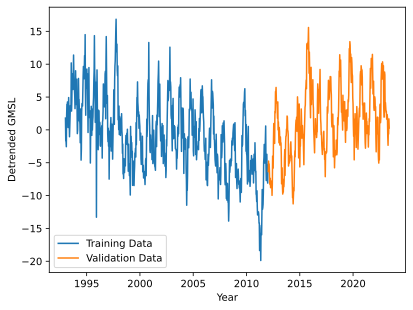

In [28]:
# According to the statement of the question, we will use the pre-processed 
# de-trended GMSL data (training and validation) here.

# get the training data(1-700)
train_data = detrended_data[:700] # 0->699

# get the validation data(701-end)
validation_data = detrended_data[700:] # 700->rest

# plot the training data and validation data
plt.plot("Year","GMSL",data = train_data,     label = 'Training Data')
plt.plot("Year","GMSL",data = validation_data,label = 'Validation Data')
plt.xlabel('Year')
plt.ylabel('Detrended GMSL')
plt.legend()
plt.show()

## 1.2 Fit an autoregressive model
We will now fit an AR$(p)$ model to the training data for a given value of the model order $p$.

**Q5**: Create a function that fits an AR$(p)$ model for an arbitrary value of p. Use this function to fit a model of order $p=10$ to the training data and write out (or plot) the coefficients.

_Hint:_ Since fitting an AR model is essentially just a standard linear regression we can make use of `lm.LinearRegression().fit(...)` similarly to above. You may use the template below and simply fill in the missing code.

**A5:**

In [29]:
def fit_ar(y, p):
    """Fits an AR(p) model. The loss function is the sum of squared errors from
      t=p+1 to t=n.

    :param y: array (n,), training data points
    :param p: int, AR model order
    :return theta: array (p,), learnt AR coefficients
    """

    # Number of training data points
    n = len(y) 
    
    # Construct the regression matri
    # According to Slide 11 of lecture 2, Phi is a (n-p)*p matrix
    Phi = np.zeros((n-p,p))  
    for j in range(p): 
        # fill Phi with y value(Slide 11 of lecture 2)
        # since python is 0 based,so all the index should -1  
        # and y[p-j-1:n-j-1]'s last element is actually n-j-2
        # and this match the index in the PPT  
        Phi[:,j] = y[p-j-1:n-j-1] 
    
    # Drop the first p values from the target vector y
    yy = y[p:]  # yy = (y_{t+p+1}, ..., y_n)

    # Here we use fit_intercept=False since we do not want to include an 
    # intercept term in the AR model
    regr = lm.LinearRegression(fit_intercept=False)
    regr.fit(Phi,yy)    

    return regr.coef_

In [30]:
# Fit an AR(10) model to the training data
p_value = 10

theta_hat = fit_ar(train_data['GMSL'], p = p_value)

# print the coefficients of the AR(10) model
print("Coefficients of the AR(10) model are \n", theta_hat)    

Coefficients of the AR(10) model are 
 [ 0.63068183  0.1231388   0.12558768  0.17683292 -0.02284342 -0.07140349
 -0.05693816  0.0479181  -0.0893176   0.0251526 ]


**Q6:** Next, write a function that computes the one-step-ahead prediction of your fitted model. 'One-step-ahead' here means that in order to predict $y_t$ at $t=t_0$, we use the actual values of $y_t$ for $t<t_0$ from the data. Use your function to compute the predictions for both *training data* and *validation data*. Plot the predictions together with the data (you can plot both training and validation data in the same figure). Also plot the *residuals*.

_Hint:_ It is enought to call the predict function once, for both training and validation data at the same time.

**A6:**

In [31]:
def predict_ar_1step(theta, y_target):
    """Predicts the value y_t for t = p+1, ..., n, for an AR(p) model, based on 
    the data in y_target using one-step-ahead prediction.

    :param theta: array (p,), AR coefficients, theta=(a1,a2,...,ap).
    :param y_target: array (n,), the data points used to compute the predictions
    :return y_pred: array (n-p,), the one-step predictions (\hat y_{p+1}, ...., 
    \hat y_n) 
    """

    n = len(y_target)
    p = len(theta)
    
    # Number of steps in prediction
    m = n-p
    # y_pred[0] is actually p+1 element, since first p element is dropped
    y_pred = np.zeros(m)
    
    for i in range(m):        
        # use new theta and y_target to predict
        y_pred[i] = np.dot(np.flip(theta),y_target[i:i+p])  
        
    return y_pred

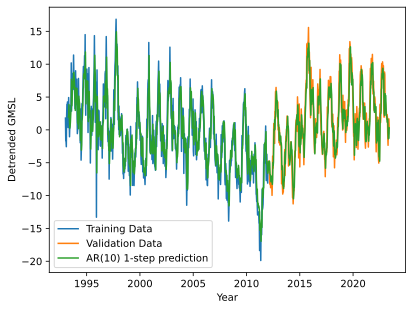

In [32]:
ar_1step_predition = predict_ar_1step(theta_hat, detrended_data['GMSL'])

# plot training data
plt.plot("Year","GMSL",data=train_data, label='Training Data')
# plot validation data
plt.plot("Year","GMSL",data=validation_data,label='Validation Data')


# plot ar 1 step prediction
plt.plot(detrended_data['Year'][p_value:], 
         ar_1step_predition, label='AR(10) 1-step prediction')
plt.xlabel('Year')
plt.ylabel('Detrended GMSL')
plt.legend()
plt.show()

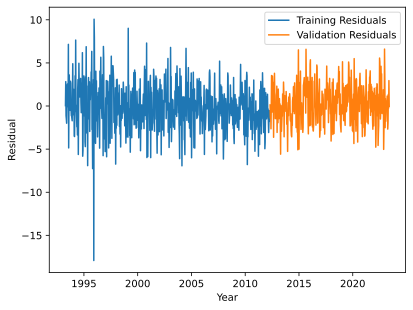

In [33]:

# create pandas resids dataframe
resids_plot_df = pandas.DataFrame({'Year': detrended_data['Year'][p_value:], 
                                   'GMSL': detrended_data['GMSL'][p_value:] 
                                           - ar_1step_predition})

# plot the residuals of Training data
plt.plot(resids_plot_df['Year'][:700],
         resids_plot_df['GMSL'][:700],
         label = "Training Residuals")

# plot the residuals of Validation data
plt.plot(resids_plot_df['Year'][700:],
         resids_plot_df['GMSL'][700:],
         label = "Validation Residuals")

plt.xlabel('Year')
plt.ylabel('Residual')

plt.legend()
plt.show()

**Q7:** Compute and plot the autocorrelation function (ACF) of the *residuals* only for the *validation data*. What conclusions can you draw from the ACF plot?

_Hint:_ You can use the function `acfplot` from the `tssltools` module, available on the course web page.

**A7:**

According to wikipedia [Autocorrelation](https://en.wikipedia.org/wiki/Autocorrelation), Autocorrelation is the correlation of a signal with a delayed copy of itself as a function of delay.

From the ACF plot below, we found that acf value drop rapidly at first, which 
means the series has short-term dependencies.

We also found that acf fluctuates around 0, which means the series has some seasonal pattern.
And it is around zero, which means it do not have a trend.(since acf is based on detrend data) 

Meanwhile, we also found that the acf's fluctuation get weaker as the lag increases, and it converges to 0 means the influence of the past value on the current value is getting weaker.

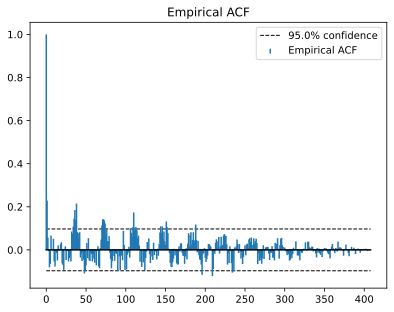

In [34]:
# get validation residual data
valid_resids = resids_plot_df['GMSL'][700:]

# valid_resids should be (n,)
acfplot(valid_resids)

## 1.3 Model validation and order selection
Above we set the model order $p=10$ quite arbitrarily. In this section we will try to find an appropriate order by validation.

**Q8**: Write a loop in which AR-models of orders from $p=2$ to $p=150$ are fitted to the data above. Plot the training and validation mean-squared errors for the one-step-ahead predictions versus the model order.

Based on your results:
- What is the main difference between the changes in training error and validation error as the order increases? 
- Based on these results, which model order would you suggest to use and why?

_Note:_ There is no obvious "correct answer" to the second question, but you still need to pick an order an motivate your choice!


**A8:**

In [35]:
p_start = 2
p_end = 150
p_num = p_end - p_start + 1
trainMSE = np.zeros(p_num)
validMSE = np.zeros(p_num)

for i in range(p_start,p_end + 1):
     theta = fit_ar(train_data['GMSL'], p = i)
     pred_ar1 = predict_ar_1step(theta, detrended_data['GMSL'])
     
     resids_df = detrended_data['GMSL'][i:] - pred_ar1

     train_resids = resids_df[:700-i]
     valid_resids = resids_df[700-i:]
     
     trainMSE[i-2] = np.mean(train_resids**2)
     validMSE[i-2] = np.mean(valid_resids**2)

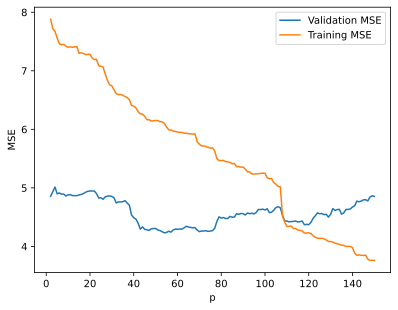

In [36]:
X_axis = range(p_start,p_end+1)
plt.plot(X_axis, validMSE, label = "Validation MSE")
plt.plot(X_axis, trainMSE, label = "Training MSE")
plt.xlabel("p")
plt.ylabel("MSE")
plt.legend()
plt.show()

In [37]:
# print the minimal valid MSE's p
print(np.where(validMSE == np.amin(validMSE)))

(array([52]),)


**Q9:** Based on the chosen model order, compute the residuals of the one-step-ahead predictions on the *validation data*. Plot the autocorrelation function of the residuals. What conclusions can you draw? Compare to the ACF plot generated above for p=10.

**A9**:

According to the slide 7 of lecture 2d, we expect the residuals to be white noise, 
which follow a gaussian distribution (in case the model is accurate)

From to the ACF plot below, we found that the most of the acf values are inside the
95% confidence interval band, which means the residuals are most likely white noises. 

So this plot is much better than the ACF plot for p=10(which has several acf values outside the 95% confidence interval band).



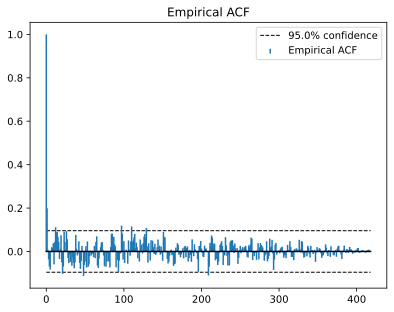

In [38]:
# According to Q8, we know that the minimal valid MSE appear when p=52
p_value = 52
theta_q9 = fit_ar(train_data['GMSL'], p = p_value)
ar_1step_predition_q9 = predict_ar_1step(theta_q9, detrended_data['GMSL'])
resids_df_q9 = detrended_data['GMSL'][p_value:] - ar_1step_predition_q9
valid_resids_q9 = resids_df_q9[700-p_value:]

acfplot(valid_resids_q9)

## 1.4 Long-range predictions
So far we have only considered one-step-ahead predictions. However, in many practical applications it is of interest to use the model to predict further into the future. For intance, for the sea level data studied in this laboration, it is more interesting to predict the level one year from now, and not just 10 days ahead (10 days = 1 time step in this data).

**Q10**: 
Write a function that simulates the value of an AR($p$) model $m$ steps into the future, conditionally on an initial sequence of data points. Specifically, given $y_{1:n}$ with $n\geq p$ the function/code should predict the values

\begin{align}
    \hat y_{t|n} &= \mathbb{E}[y_{t} | y_{1:n}], & t&=n+1,\dots,n+m.
\end{align}

Use this to predict the values for the validation data ($y_{701:997}$) conditionally on the training data ($y_{1:700}$) and plot the result.

_Hint:_ Use the pseudo-code derived at the first pen-and-paper session.

**A10:**

In [39]:
def simulate_ar(y, theta, m):
    """Simulates an AR(p) model for m steps, with initial condition given by 
       the last p values of y
    
    :param y: array (n,) with n>=p. The last p values are used to initialize 
              the simulation.
    :param theta: array (p,). AR model parameters,
    :param m: int, number of time steps to simulate the model for.
    """

    p = len(theta)    
    y_sim = np.zeros(m)
    # (y_{n-1}, ..., y_{n-p})^T - note that y[ntrain-1] is the last 
    # training data point
    phi = np.flip(y[-p:].copy()) 

    for i in range(m):
        y_sim[i] = np.dot(theta,phi)  # next step                
        # according to slide 11 of lecture 2c, we remove last column, 
        # and add new one as 1st column
        phi = np.concatenate([y_sim[i:i+1], phi[:-1]])

    return y_sim
    

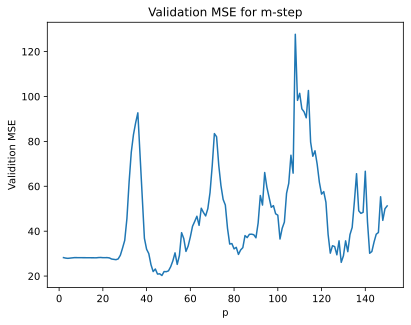

We get minimal validation MSE when p = 45


In [40]:
# we will do the same in Q8, but replace the predict_ar_1step with the new 
# created simulate_ar function and calculate the validation MSE

# p value from 2 to 150 which is defined before
validMSE_simulate = np.zeros(p_num)

for i in range(p_start,p_end + 1):
    theta = fit_ar(train_data['GMSL'], p = i)
    pred_sim = simulate_ar(train_data['GMSL'],theta=theta,m=len(validation_data))
     
    validation_resids = validation_data['GMSL'] - pred_sim
                 
    validMSE_simulate[i-2] = np.mean(validation_resids**2)

plt.plot(X_axis, validMSE_simulate)
plt.title("Validation MSE for m-step")
plt.xlabel("p")
plt.ylabel("Validition MSE")
plt.show()

# print the minimal valid MSE's p
minimal_p = np.where(validMSE_simulate == np.amin(validMSE_simulate))[0][0]
print("We get minimal validation MSE when p =",minimal_p)

In [41]:
p_value = minimal_p
theta_new = fit_ar(train_data['GMSL'], p=p_value)

**Q11:** Using the same function as above, try to simulate the process for a large number of time steps (say, $m=2000$). You should see that the predicted values eventually converge to a constant prediction of zero. Is this something that you would expect to see in general? Explain the result.

**A11:**

According to the plot below, we can find that the predicted values eventually converge to a constant prediction of zero. This is mainly because the data we use are detrended data, which it's mean is zero. And from the begining of the exercises, we did not add ant noises inside, 
so the predicted values eventually converge to a constant prediction of zero is something that we would expect to see in general.

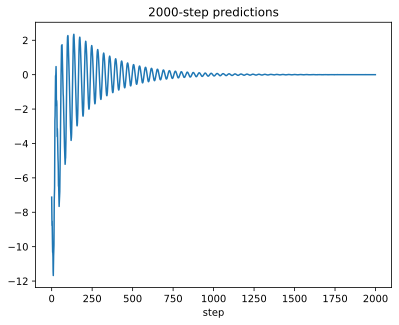

In [42]:
# 2000 steps prediction
# we use the new theta just generated (p=theta_new)
predictions_2000 = simulate_ar(train_data['GMSL'], 
                               np.transpose(theta_new),m = 2000)

plt.plot(predictions_2000)
plt.xlabel("step")
plt.title("2000-step predictions")
plt.show()

## 1.5 Nonlinear AR model
 In this part, we switch to a nonlinear autoregressive (NAR) model, which is based on a feedforward neural network. This means that in this model the recursive equation for making predictions is still in the form $\hat y_t=f_\theta(y_{t-1},...,y_{t-p})$, but this time $f$ is a nonlinear function learned by the neural network. Fortunately almost all of the work for implementing the neural network and training it is handled by the `scikit-learn` package with a few lines of code, and we just need to choose the right structure, and prepare the input-output data.   

**Q12**: Construct a NAR($p$) model with a feedforward (MLP) network, by using the `MLPRegressor` class from `scikit-learn`. Set $p$ to the same value as you chose for the linear AR model above. Initially, you can use an MLP with a single hidden layer consisting of 10 hidden neurons. 
Train it using the same training data as above and plot the one-step-ahead predictions as well as the residuals, on both the training and validation data. 

_Hint:_ You will need the methods `fit` and `predict` of `MLPRegressor`. Read the user guide of `scikit-learn` for more details. Recall that a NAR model is conceptuall very similar to an AR model, so you can reuse part of the code from above.

**A12:**

As we can see from the plot below, the validation and training prediction did not cover all the original data, and only cover half of them. According to the warning message that generated, we found that the model did not converge in default setting(200 max iter number), which means the model did not learn the data well, and it may explain what we found here. So we increase it to 2000, and the result is better than the previous one, but still have several points that are not covered by the prediction.

/Users/pierre/.pyenv/versions/3.11.9/envs/machine-learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


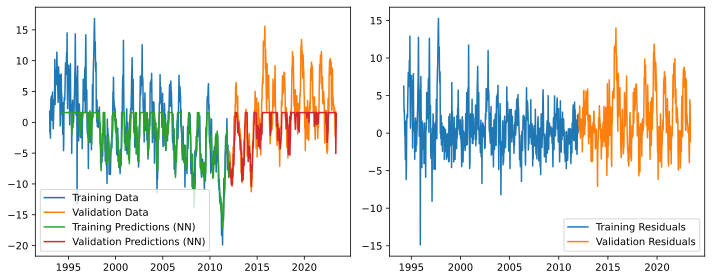

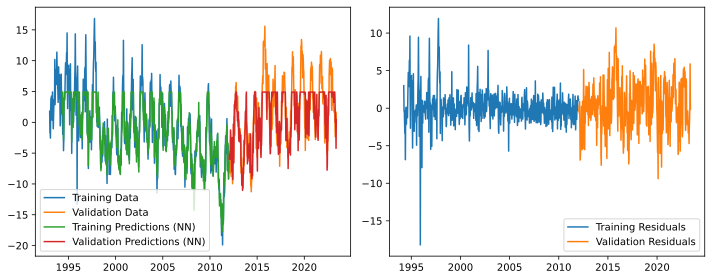

In [43]:
def fit_nar_nn(train_data,validation_data,p_value,
               neurons_num=10,hidden_layer_num=1,               
               max_iter=200,solver="adam",
               activation="relu"):

    # process training data
    n_train = len(train_data)

    # construct the regression matrix for training data
    Phi_train_nn = np.zeros((n_train-p_value,p_value))  

    for j in range(p_value):         
        Phi_train_nn[:,j] = train_data['GMSL'][p_value-j-1:n_train-j-1] 
        
    # Drop the first p values from the target vector y
    yy_train_nn = train_data['GMSL'][p_value:]  # yy = (y_{t+p+1}, ..., y_n)

    # call MLPRegressor function
    # default values
    # activation='relu' {‘identity’, ‘logistic’, ‘tanh’, ‘relu’}
    # solver='adam' {‘lbfgs’, ‘sgd’, ‘adam’}
    # learning_rate_init=0.001
    # max_iter=200
    # early_stopping=False

    MLP = MLPRegressor(hidden_layer_sizes=(neurons_num,hidden_layer_num),
                       max_iter=max_iter,
                       solver=solver,
                       activation=activation)

    MLP.fit(Phi_train_nn,yy_train_nn)

    # 1 step predition
    nn_train_1step_predition = MLP.predict(Phi_train_nn)

    # validation data
    # to predict all the data in validation, we need to add P data points from 
    # train to the begining of the validation data set
    new_validation_data = pandas.concat([train_data[n_train - p_value:], 
                                        validation_data], ignore_index=True)

    n_validation = len(new_validation_data)

    # construct the regression matrix for validation data
    Phi_validation_nn = np.zeros((n_validation - p_value, p_value))  

    for j in range(p_value):         
        Phi_validation_nn[:,j] = new_validation_data['GMSL'][p_value - j - 1:
                                                            n_validation - j - 1] 
    # 1 step predictation
    nn_validation_1step_predition = MLP.predict(Phi_validation_nn)

    #Residuals
    residual_train = train_data['GMSL'][p_value:] - nn_train_1step_predition
    residual_validation = new_validation_data['GMSL'][p_value:] - \
                        nn_validation_1step_predition

    # Create a figure with 2 subplots in 1 row and 2 columns
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    
    # plot training data
    ax[0].plot("Year","GMSL",data=train_data, label='Training Data')
    # plot validation data
    ax[0].plot("Year","GMSL",data=validation_data, label='Validation Data')

    
    # plot predictions for train and validation
    ax[0].plot(train_data['Year'][p_value:],nn_train_1step_predition, 
            label='Training Predictions (NN)')
    ax[0].plot(new_validation_data['Year'][p_value:],nn_validation_1step_predition, 
            label='Validation Predictions (NN)')
    ax[0].legend()
    
    # plot residuals
    ax[1].plot(train_data['Year'][p_value:],residual_train, label = "Training Residuals")
    ax[1].plot(new_validation_data['Year'][p_value:],residual_validation, label = "Validation Residuals")
    ax[1].legend()
    
    plt.tight_layout()  # Adjust layout to avoid overlap
    plt.show()

# we will use p = minimal_p = 45 
p_value = minimal_p

# neurons number
neurons_num = 10

hidden_layer_num = 1

fit_nar_nn(train_data=train_data,validation_data=validation_data,
           neurons_num=neurons_num,hidden_layer_num = hidden_layer_num,
           p_value=p_value)

fit_nar_nn(train_data=train_data,validation_data=validation_data,
           neurons_num=neurons_num,hidden_layer_num = hidden_layer_num,
           p_value=p_value,max_iter=2000)

**Q13:** Try to expirement with different choices for the hyperparameters of the network (e.g. number of hidden layers and units per layer, activation function, etc.) and the optimizer (e.g. `solver` and `max_iter`).

Are you satisfied with the results? Why/why not? Discuss what the limitations of this approach might be.

**A13:**

We try different combinations:

1.  hidden layer number = 50 and neurons_num = 50
2.  hidden layer number = 20 and neurons_num = 10
3.  hidden layer number = 3 and neurons_num = 10
4.  neurons_num=10,hidden_layer_num=1(which is default here), but set activation=tanh and solver=sgd

From the the experiment result below, we can find that when we make the NN more complex, the prediction will get better. We also found that although the Training residuals get very small, but the validation still too big compare to the training residuals, so we think complex NN model may over fit our data. But when we set hidden layer number = 3 and neurons_num = 10, we got a pretty good result.

Meanwhile, we found that change activation and solver can make the model get better according to the coverage rate of the plot.

So one of the model (third one) we use  is good, but we still can improve it. Which means combine not too complicated NN with suitable activation and solver, we can get a better result.


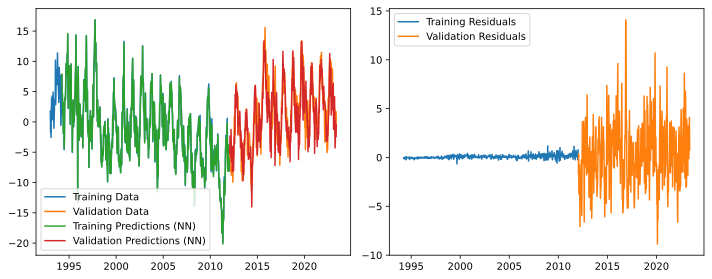

In [44]:
# we use neurons_num = 50 and hidden_layer_num = 50

fit_nar_nn(train_data=train_data,validation_data=validation_data,
           neurons_num=50,
           hidden_layer_num=50,
           p_value=p_value,max_iter=2000)

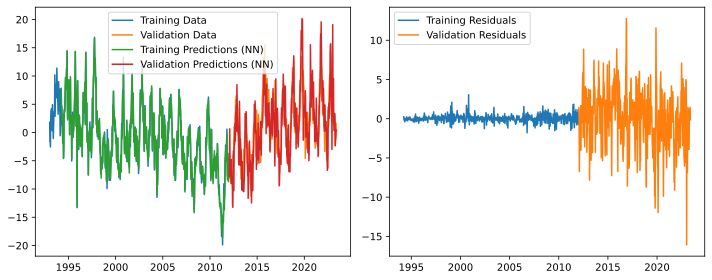

In [45]:
# we use neurons_num = 20 and hidden_layer_num = 10

fit_nar_nn(train_data=train_data,validation_data=validation_data,
           neurons_num=20,
           hidden_layer_num=10,
           p_value=p_value,max_iter=2000)

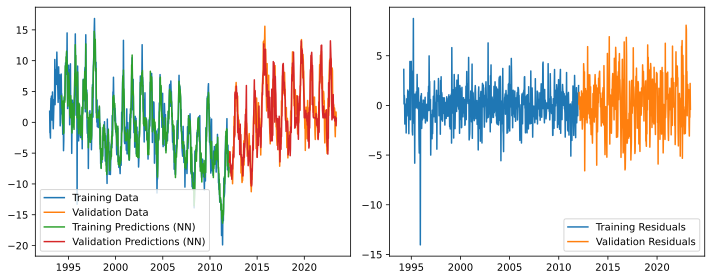

In [46]:
# we use neurons_num = 10 and hidden_layer_num = 3

fit_nar_nn(train_data=train_data,validation_data=validation_data,
           neurons_num=10,
           hidden_layer_num=3,
           p_value=p_value,max_iter=2000)

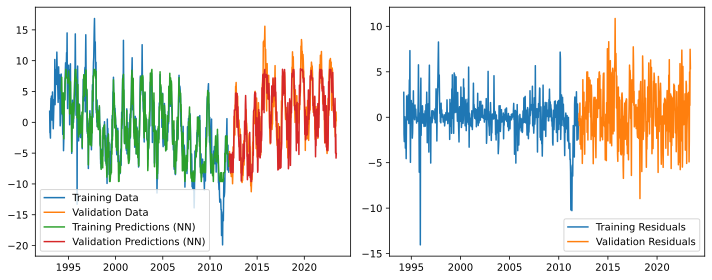

In [47]:
# we change activation function to 'tanh' and solver to 'sgd'

fit_nar_nn(train_data=train_data,validation_data=validation_data,
           neurons_num=10,
           hidden_layer_num=1,
           p_value=p_value,
           max_iter=2000,
           activation='tanh',
           solver='sgd')